### Simulating an Ising Model with Glauber Dynamics


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


### Glauber Dynamics Algorithm
Single iteration:
1. Choose a random site $\sigma$.
2. Sum its four neighboring spins S.
3. Energy $E = 2\sigma S$
4. $\textbf{P}(flip)=\frac{1}{1+e^{E/T}}$ ; T = Temperature

In [ ]:
class GlauberDynamics:
    """
    A class for simulating the spin flips in an Ising Model

    Args:
        grid (array): Lattice of particles' spins, -1 = down | +1 = up
        temp (float, opt.): Temperature of the model. Default is 0
        seed (float, opt.): Random seed for simulation, Default is None
        store_history (bool, opt.): Keeps a record of past steps. Default is False.

    Attributes:
        history (list, opt.): Record of past grids

    Methods:
        step: Simulate a single step of the process
        run: Simulate the process for a given number of steps

    Notes:
        Algorithm used: https://en.wikipedia.org/wiki/Glauber_dynamics
    """
    def __init__(self, grid, temp= 0, seed= None, store_history= False):
        np.random.seed(seed)
        self.grid = grid
        self.temp = temp
        # boundary conditions, edges are given values of 0
        self.grid_copy = np.pad(grid, pad_width= 1)
        self.history = [self.grid_copy.copy()]
        self.store_history = store_history
        
        pass
    
    def step(self):
        """Chooses a random lattice site and determines if it flips."""
        i = np.random.randint(1, len(self.grid_copy) - 1)
        j = np.random.randint(1, len(self.grid_copy[0]) - 1)

        spin_sum = self.grid_copy[i+1][j] + self.grid_copy[i][j+1] + self.grid_copy[i-1][j] + self.grid_copy[i][j-1]
        del_E = 2*self.grid_copy[i][j]*spin_sum

        if self.temp != 0:
            p = 1/(1 + np.e**(del_E/self.temp))
        else:
            if del_E < 0:
                p = 1
            else: # assumes that non-ferromagnetic(del_E == 0) sites don't change
                p = 0

        if np.random.rand() < p:
            self.grid_copy[i][j] *= -1


    def run(self, n):
        """
        Simulates spin flips for n_steps.

        Args:
            n (int): The number of steps to simulate
        """    
        for i in range(n):
            self.step()
            if self.store_history == True and not np.array_equal(self.history[-1],self.grid_copy):
                self.history.append(self.grid_copy.copy())


    def get_energy(self):
        """Computes the total energy of the lattice by summing all neighboring interactions"""
        energy = np.sum(np.multiply(self.grid_copy[1:-1,1:-1],
                             self.grid_copy[:-2,1:-1] + self.grid_copy[2:,1:-1] + self.grid_copy[1:-1,2:] + self.grid_copy[1:-1,:-2]))
        return energy


    def __str__(self):
        """
        Prints the current grid. Red = Up | Blue = Down | White = Boundary
        """
        plt.figure()
        plt.imshow(self.grid_copy, cmap='coolwarm')
        plt.title(f"Temperature:{self.temp}")
        return ""

Test


18

42


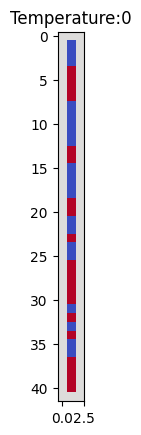

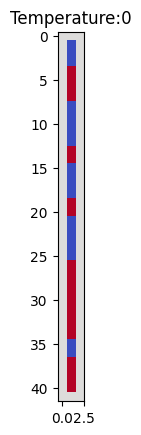

In [6]:
myGrid = np.random.choice((-1,1), size= (40,1))
# myGrid = np.array([-1,-1,-1,-1,-1,-1,1,1,1,1,1,1])[:,None]

model = GlauberDynamics(myGrid, temp= 0, store_history= False, seed= 1) # Critical temp = 2.27
print(model)
print(model.get_energy())
model.run(10000)
print(model)
print(model.get_energy())

Animation

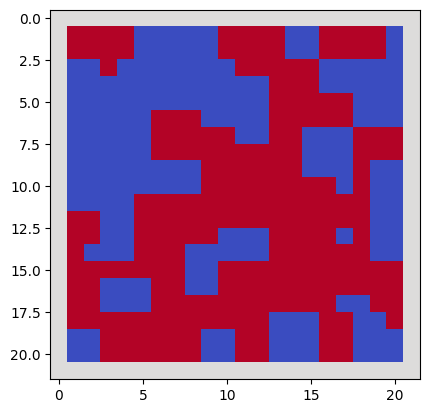

In [13]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parameters for the grid
myGrid = np.random.choice((-1,1), size= (20,20))  # Grid creation
n_steps = 1000         # Number of frames in the animation

#Assign the model using the GlauberDynamics class
model=GlauberDynamics(myGrid, temp= 0, store_history= True, seed= 0)

# Run simulation n times
model.run(n_steps)


# Set up the figure and initial plot
fig, ax = plt.subplots()
im = ax.imshow(model.history[0], cmap='coolwarm', vmin=-1, vmax=1)

# Initialization function: displays the first frame
def init():
    im.set_data(model.history[0])
    return [im]

# Update function: updates the image data for each frame
def update(frame):
    im.set_data(model.history[frame])
    return [im]

ani = FuncAnimation(fig, update, frames=len(model.history), init_func=init, blit=True, interval=50)

HTML(ani.to_jshtml())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

### The logic for connections
class Honeycomb:

    def __init__(self, graph, temp, seed= None):
        self.graph = np.pad(graph, pad_width= 1)
        self.temp = temp
        np.random.seed(seed)


    def get_energy(self, r, c) -> int:
        """Returns the energy of a given site"""
        spin_sum = self.graph[r][c+1] + self.graph[r][c-1]
        
        if c-1 % 4 == 0:
            spin_sum += self.graph[r+1][c+1]
        elif c-2 % 4 == 0:
            spin_sum += self.graph[r-1][c-1]
        elif c-3 % 4 == 0:
            spin_sum += self.graph[r-1][c+1]
        elif c % 4 == 0:
            spin_sum += self.graph[r+1][c-1]

        del_E = 2*self.graph[r][c]*spin_sum

        return del_E
    

    def get_totalenergy(self):
        """Returns the total energy of the lattice"""
        total_energy = 0
        for r in range(1, np.shape(self.graph)[0] - 1):
            for c in range(1, np.shape(self.graph)[1] - 1):
                 total_energy += self.get_energy(r,c)
        
        return total_energy


    def _step(self) -> None:
        r = np.random.randint(1, np.shape(self.graph)[0] - 1)
        c = np.random.randint(1, np.shape(self.graph)[1] - 1)

        del_E = self.get_energy(r,c)

        if self.temp != 0:
            p = 1/(1 + np.e**(del_E/self.temp))
        else:
            if del_E < 0:
                p = 1
            else:
                p = 0

        if np.random.rand() < p:
            self.graph[r][c] *= -1

    def run(self, iter) -> None:
        for i in range(iter):
            self._step()
                 

    def plot(self, scale= 1):
        x = []
        y = []
        z = []
        for r in range(np.shape(self.graph)[0]):
            x_coord = 0
            for c in range(np.shape(self.graph)[1]):
                # checks if on column(2,3 , 6,7 , 10,11...) -> vertically displaces
                if (c+1) % 4 == 0 or (c+2) % 4 == 0:
                    y_shift = (np.sqrt(3) / 2) * scale
                else:
                    y_shift = 0

                x.append(x_coord)
                y.append(np.sqrt(3)*scale*r + y_shift)
                z.append(self.graph[r][c])

                if c % 2 == 0:
                    x_coord += scale
                else:
                    x_coord += (scale / 2)

        plt.figure(figsize=(8, 8))
        sc = plt.scatter(x, y, c=z, cmap='coolwarm', edgecolor='k')

        cbar = plt.colorbar(sc)
        cbar.set_label('Spin (color scale)')

        plt.xlabel('X-axis')
        plt.ylabel("Y-axis")
        plt.title('Honeycomb Ising Model')
        plt.axis('equal')





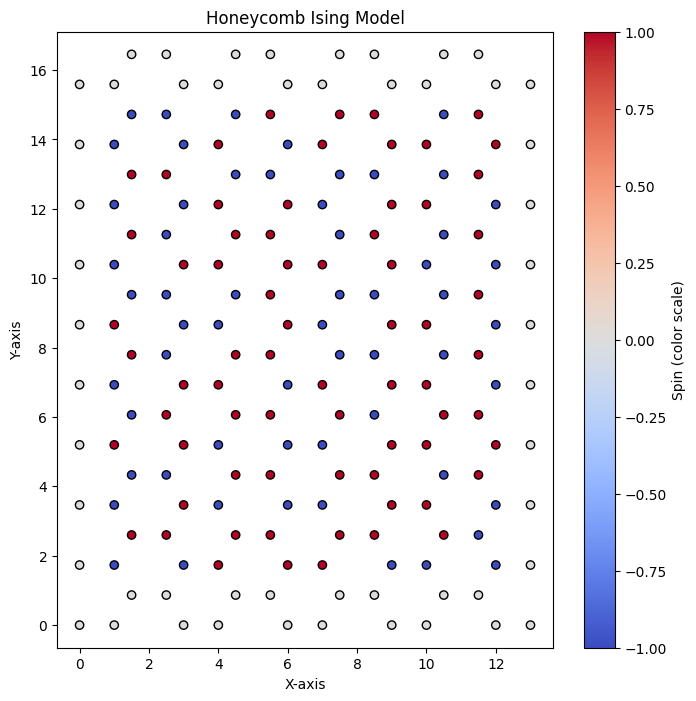

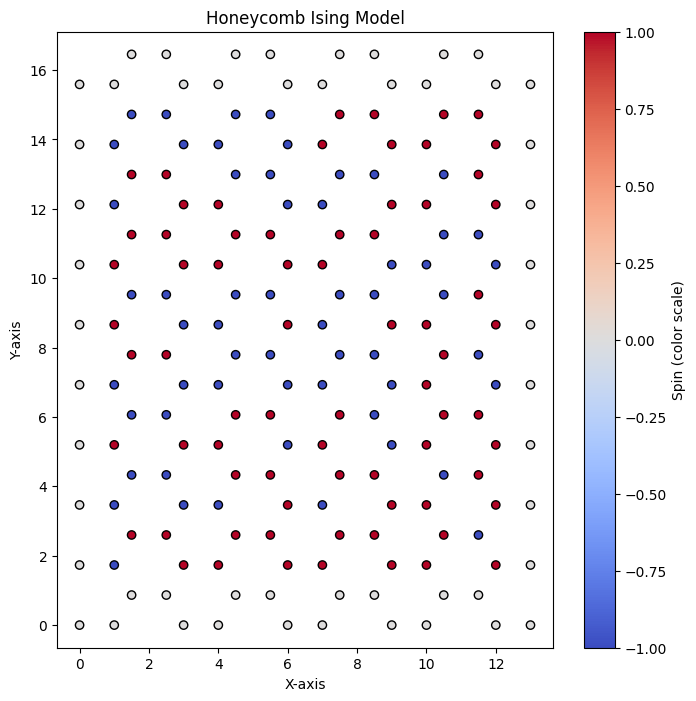

In [36]:
mygraph = np.random.choice((-1,1), size= (8,16))

myModel = Honeycomb(graph= mygraph, temp= 0.1, seed= 0)

myModel.plot()
myModel.run(iter=100)
myModel.plot()
